## Load in data

In [1]:
import pickle 
import os
def load_pickled_file(filename: str):
    with open(filename, 'rb') as file:
        loaded_object = pickle.load(file)
    return loaded_object

results_dir = "./data/min_5_at_5_percent"
true_values = load_pickled_file(os.path.join(results_dir, "./positive_positive_true_values.pickle"))
predicted_values = load_pickled_file(os.path.join(results_dir, "./positive_positive_predictions.pickle"))
print(true_values.shape)
print(predicted_values.shape)

(8778, 8778)
(8778, 8778)


In [2]:
from matchms.importing.load_from_mgf import load_from_mgf
val_spectra = list(load_from_mgf(os.path.join(results_dir, "./positive_validation_spectra.mgf")))
print(len(val_spectra))

8778


## Plot the diagonal

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def remove_diagonal(matrix):
    """Removes the diagonal from a matrix

    meant for removing matches of spectra against itself. """
    # Get the number of rows and columns
    nr_of_rows, nr_of_cols = matrix.shape
    if nr_of_rows != nr_of_cols:
        raise ValueError("Expected predictions against itself")

    # Create a mask for the diagonal elements
    diagonal_mask = np.eye(nr_of_rows, dtype=bool)
    # Use the mask to remove the diagonal elements
    matrix_without_diagonal = matrix[~diagonal_mask].reshape(nr_of_rows, nr_of_cols - 1)
    return matrix_without_diagonal

def select_indexes_per_inchikey(inchikey, val_spectra):
    matching_spectrum_ids = []
    for spectrum_id, spectrum in enumerate(val_spectra):
        if spectrum.get("inchikey")[:14] == inchikey:
            matching_spectrum_ids.append(spectrum_id)
    return matching_spectrum_ids

def select_inchikeys(val_spectra):
    list_of_inchikeys = []
    for spectrum in val_spectra:
        inchikey = spectrum.get("inchikey")[:14]
        list_of_inchikeys.append(inchikey)
    return np.array(list_of_inchikeys)
    
def select_matrixes_per_inchikey(val_spectra, predicted_values, include_diagonal):
    inchikeys = select_inchikeys(val_spectra)
    mean_predictions_per_inchikey = []
    for inchikey in np.unique(inchikeys):
        matching_spectrum_ids = np.where(inchikeys == inchikey)[0]
        matrix_of_predictions_for_inchikey = predicted_values[matching_spectrum_ids][:,  matching_spectrum_ids]
        if include_diagonal is False:
            matrix_of_predictions_for_inchikey = remove_diagonal(matrix_of_predictions_for_inchikey)
        if matrix_of_predictions_for_inchikey.shape[1] > 0:
            max_per_row = np.max(matrix_of_predictions_for_inchikey, axis=1)
            mean_prediction = np.mean(matrix_of_predictions_for_inchikey)
            mean_predictions_per_inchikey.append(mean_prediction)
    return mean_predictions_per_inchikey

def plot_mean_prediction_between_same_inchikey(val_spectra, predicted_values, include_diagonal):
    mean_predictions_per_inchikey = select_matrixes_per_inchikey(val_spectra, predicted_values, include_diagonal)
    plt.hist(mean_predictions_per_inchikey, np.linspace(0,1, 21), rwidth=0.9)
    plt.ylabel("Count of average predictions per inchikey")
    plt.xlabel("MS2Deepscore")
    plt.title("Prediction between spectra of the same inchikey")
    plt.show()

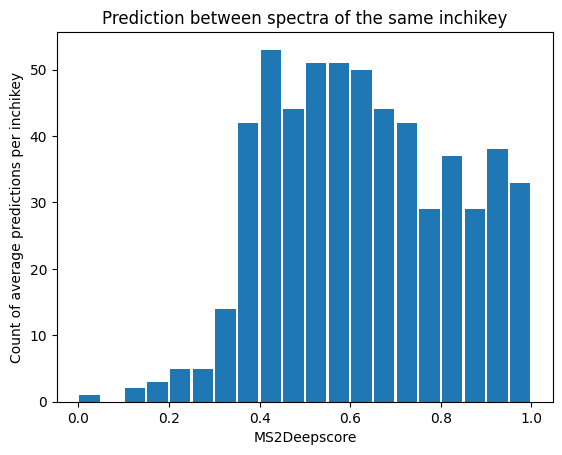

In [32]:
mean_predictions_per_inchikey = plot_mean_prediction_between_same_inchikey(val_spectra, predicted_values, False)
